In [1]:
import os
import random
import metpy
import datetime
import s3fs
import numpy as np
import pandas as pd
import xarray as xr
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image
from pyresample import geometry, grid
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from skimage.filters import laplace
from skimage.filters import unsharp_mask
from skimage.transform import resize
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

fs = s3fs.S3FileSystem(anon = True)
model = hub.load("https://tfhub.dev/captain-pool/esrgan-tf2/1")
random.seed(42)
graph_min = 200
graph_max = 375

/sharedData2/nshakoor/.conda/envs/fires/lib/python3.7/site-packages/pyresample/bilinear/__init__.py:49: UserWarning: XArray and/or zarr not found, XArrayBilinearResampler won't be available.
  warnings.warn("XArray and/or zarr not found, XArrayBilinearResampler won't be available.")


In [178]:
filedates = set()
files = []

for file in os.listdir('../../GOES_Files/npy_files'):
    filedates.add(file[27:41])

for file in os.listdir('../../GOES_Files/clear_sky_mask'):
    if file[23:37] in filedates:
        files.append(file)

In [89]:
def find_npy_file(path, file, band):
    """
    Returns the string name of another file from the same time for a given GOES band npy file,
    or None if there is no such file in the given directory.
    
    Parameter path: The path where the returned file is located in
    Precondition: path is a string to a directory relative to the current one, with .npy files
    
    Parameter file: A file from the same time the returned file should have
    Precondition: file is a string with the name of the original file, and includes the path
    
    Parameter band: GOES band the returned file should be from
    Precondition: band is a string of length 2
    """
    for x in os.listdir(path):
        if x[19:21] == band and file[23:37] == x[27:41]:
            return x

def fire_threshold(img07, img14):
    m = (330-210)/(340-295)
    b = 210 - m*295
    
    fire_mask = (img14) < (m*img07 + b)
    points = np.array(fire_mask.nonzero()).T
    
    for point in points:
        save = point[0]
        point[0] = point[1]
        point[1] = 500 - save
        
    return points

def fire_mask(img07, img14):
    m = (330-210)/(340-295)
    b = 210 - m*295
    return (img14) < (m*img07 + b)

def dice_score(x, y):
    numerator = 2*np.count_nonzero(np.logical_and(x, y))
    denominator = np.count_nonzero(x) + np.count_nonzero(y)
    return numerator/denominator

def other_stats(x, y):
    false_positives = np.logical_and(np.logical_not(x), y)
    false_negatives = np.logical_and(x, np.logical_not(y))
    #true positive rate
    TPR = np.count_nonzero(x)/(np.count_nonzero(x) + np.count_nonzero(false_negatives))
    #positive predictive value
    PPV = np.count_nonzero(x)/(np.count_nonzero(x) + np.count_nonzero(false_positives))
    return [false_positives, false_negatives, TPR, PPV]

In [140]:
def control_img(img):
    """
    Returns a dictionary of errors for the given file without sharpening.
    
    Parameter path: The path to the given file
    Precondition: path is a string
    
    Parameter file: The file to evaluate the error of
    Precondition: file is a string
    """
    height, width = img.shape
    smallimg = resize(img, (round(height/2), round(width/2)))
    control = resize(smallimg, (height, width))
    return control

def laplace_sharpening_img(img):
    """
    Returns a dictionary of errors for the given file using laplace sharpening.
    
    Parameter path: The path to the given file
    Precondition: path is a string
    
    Parameter file: The file to perform laplace sharpening on
    Precondition: file is a string
    """
    height, width = img.shape
    smallimg = resize(img, (round(height/2), round(width/2)))
    blurryimg = resize(smallimg, (height, width))
    laplace_edges = laplace(blurryimg)
    sharpimg = blurryimg + 0.8*laplace_edges
    return sharpimg

def unsharpmask_sharpening_img(img):
    """
    Returns a dictionary of errors for the given file using unsharpmask sharpening. To normalize images,
    each image is divided by its maximum value, and then multiplied by the same value after sharpening
    is completed.
    
    Parameter path: The path to the given file
    Precondition: path is a string
    
    Parameter file: The file to perform laplace sharpening on
    Precondition: file is a str
    """
    height, width = img.shape
    smallimg = resize(img, (round(height/2), round(width/2)))
    blurryimg = resize(smallimg, (height, width))
    sharpimg = unsharp_mask(blurryimg/blurryimg.max(), radius=1, amount=1)*blurryimg.max()
    return sharpimg

In [228]:
def load_image(array):
    """
    Returns loaded .npy file.
    
    Parameter path: Path to load .npy file from
    Precondition: path is a string
    """
    result = np.zeros((array.shape[0], array.shape[1], 3))
    result[:,:,0]= array
    result[:,:,1]= array
    result[:,:,2]= array
    return result

def preprocess_image(array):
    """
    Returns preprocessed input array.
    
    Parameter array: array to preprocess
    Precondition: array is a numpy array
    """
    hr_image = array
    hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 2) * 2
    hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
    hr_image = tf.cast(hr_image, tf.float32)
    return tf.expand_dims(hr_image, 0)

def downscale_image(image):
    """
    Returns low resolution image after scaling down input image using nearest neighbor downsampling.

    Parameter image: 3D of 4D tensor of preprocessed image
    Precondition: image is a tensor
    """
    height, width = image.shape
    result = np.zeros((image.shape[0]//2, image.shape[1]//2, 3))
    smallimg = resize(image, (round(height/2), round(width/2)))
    result[:,:,0] = smallimg
    result[:,:,1] = smallimg
    result[:,:,2] = smallimg
    lr_image = tf.expand_dims(result, 0)
    lr_image = tf.cast(lr_image, tf.float32)
    return lr_image

def esrgan_sharpening_img(image):
    """
    Returns dictionary containing errors after using the ESRGAN model.
    
    Parameter path: path of image not including file name
    Precondition: path is a string
    
    Parameter file: file of the image
    Precondition: file is a string of a .npy file
    """
    hr_image = preprocess_image(load_image(image))
    lr_image = downscale_image(image)
    fake_image = model(lr_image)
    fake_image = tf.squeeze(fake_image)

    hr_image = tf.squeeze(hr_image).numpy()
    lr_image = tf.squeeze(lr_image).numpy()
    lr_image = resize(lr_image, (hr_image.shape[0], hr_image.shape[1], 3)).ravel()
    fake_image = resize(fake_image.numpy(), (hr_image.shape[0], hr_image.shape[1], 3))

    return np.mean(fake_image, axis=2)

In [237]:
mean = []
std = []

path = '../../GOES_Files/npy_files/'
pathCM = '../../GOES_Files/clear_sky_mask/'

isFire = False

while isFire == False:
    try:
        CM = random.choice(files)
        files.remove(CM)

        file07 = find_npy_file('../../GOES_Files/npy_files', CM, '07')
        file14 = find_npy_file('../../GOES_Files/npy_files', CM, '14')

        img07 = np.load(path + file07)
        img14 = np.load(path + file14)

        cloud_mask = np.load(pathCM + CM)
        cloud_mask = cloud_mask.astype(bool)
        
        fires = np.logical_and(fire_mask(img07, img14), np.logical_not(cloud_mask))
        
        if np.count_nonzero(fires) != 0:
            isFire = True
        
    except:
        pass

print("number of fire pixels under clouds: " + str(np.count_nonzero(fire_mask(img07, img14))))
print("number of true fire pixels: " + str(np.count_nonzero(fires)))

number of fire pixels under clouds: 549
number of true fire pixels: 12


/sharedData2/nshakoor/.conda/envs/fires/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  import sys


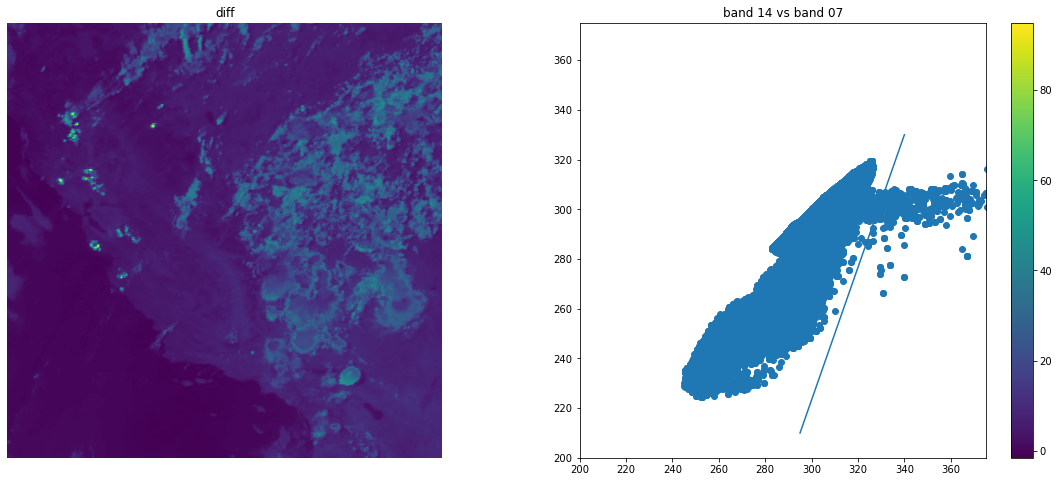

In [238]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8), gridspec_kw={'width_ratios': [1, 1]})

diff = img07 - img14
im = ax[0].imshow(diff, aspect='equal')
ax[0].set_title('diff')
ax[0].axis('off')
fig.colorbar(im)

ax[1].scatter(img07, img14)
ax[1].plot([295, 340], [210, 330], label='fires')
ax[1].set_xlim([graph_min, graph_max])
ax[1].set_ylim([graph_min, graph_max])
ax[1].set_title('band 14 vs band 07')

plt.show()

## Control

number of fire pixels: 18
dice score: 0.8
false positive count: 6
false negative count: 0
true positive rate: 1.0
positive predictive value: 0.6666666666666666


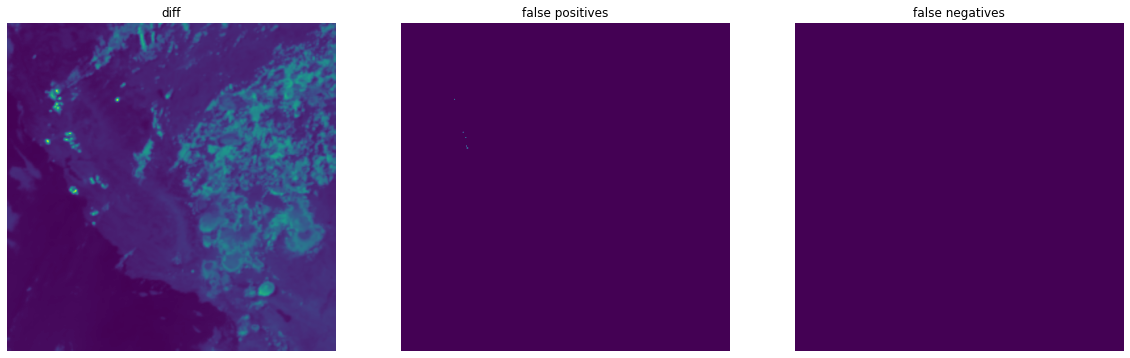

Text(0.5, 1.0, 'fire locations')

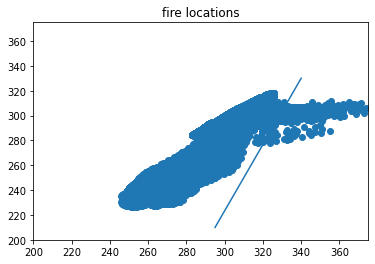

In [239]:
data07 = control_img(img07)
data14 = control_img(img14)
datafires = fire_mask(data07, data14)
datafires = np.logical_and(datafires, np.logical_not(cloud_mask))
stats = other_stats(fires, datafires)
print("number of fire pixels: " + str(np.count_nonzero(datafires)))
print("dice score: " + str(dice_score(fires, datafires)))
print("false positive count: " + str(np.count_nonzero(stats[0])))
print("false negative count: " + str(np.count_nonzero(stats[1])))
print("true positive rate: " + str(stats[2]))
print("positive predictive value: " + str(stats[3]))

fig, ax = plt.subplots(1, 3, figsize=(20, 10), gridspec_kw={'width_ratios': [1, 1, 1]})

diff = data07 - data14
im = ax[0].imshow(diff, aspect='equal')
ax[0].set_title('diff')
ax[0].axis('off')
# fig.colorbar(im)

im = ax[1].imshow(stats[0], aspect='equal')
ax[1].set_title('false positives')
ax[1].axis('off')

im = ax[2].imshow(stats[1], aspect='equal')
ax[2].set_title('false negatives')
ax[2].axis('off')

plt.show()

plt.scatter(data07, data14)
plt.plot([295, 340], [210, 330], label='fires')
plt.xlim([graph_min, graph_max])
plt.ylim([graph_min, graph_max])
plt.title('fire locations')

## Laplace

number of fire pixels: 18
dice score: 0.8
false positive count: 6
false negative count: 0
true positive rate: 1.0
positive predictive value: 0.6666666666666666


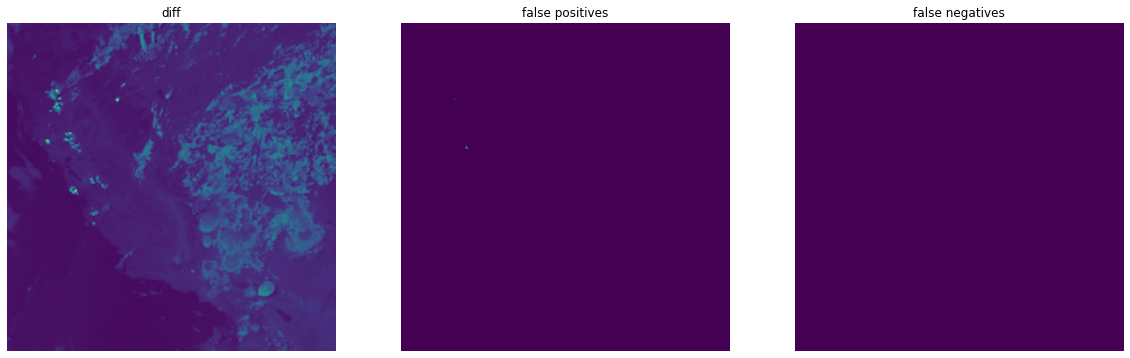

Text(0.5, 1.0, 'fire locations')

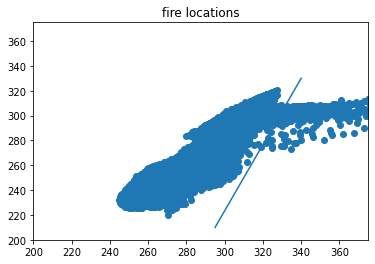

In [240]:
data07 = laplace_sharpening_img(img07)
data14 = laplace_sharpening_img(img14)
datafires = fire_mask(data07, data14)
datafires = np.logical_and(datafires, np.logical_not(cloud_mask))
stats = other_stats(fires, datafires)
print("number of fire pixels: " + str(np.count_nonzero(datafires)))
print("dice score: " + str(dice_score(fires, datafires)))
print("false positive count: " + str(np.count_nonzero(stats[0])))
print("false negative count: " + str(np.count_nonzero(stats[1])))
print("true positive rate: " + str(stats[2]))
print("positive predictive value: " + str(stats[3]))

fig, ax = plt.subplots(1, 3, figsize=(20, 10), gridspec_kw={'width_ratios': [1, 1, 1]})

diff = data07 - data14
im = ax[0].imshow(diff, aspect='equal')
ax[0].set_title('diff')
ax[0].axis('off')
# fig.colorbar(im)

im = ax[1].imshow(stats[0], aspect='equal')
ax[1].set_title('false positives')
ax[1].axis('off')

im = ax[2].imshow(stats[1], aspect='equal')
ax[2].set_title('false negatives')
ax[2].axis('off')

plt.show()

plt.scatter(data07, data14)
plt.plot([295, 340], [210, 330], label='fires')
plt.xlim([graph_min, graph_max])
plt.ylim([graph_min, graph_max])
plt.title('fire locations')

## Unsharp Mask

number of fire pixels: 18
dice score: 0.8
false positive count: 6
false negative count: 0
true positive rate: 1.0
positive predictive value: 0.6666666666666666


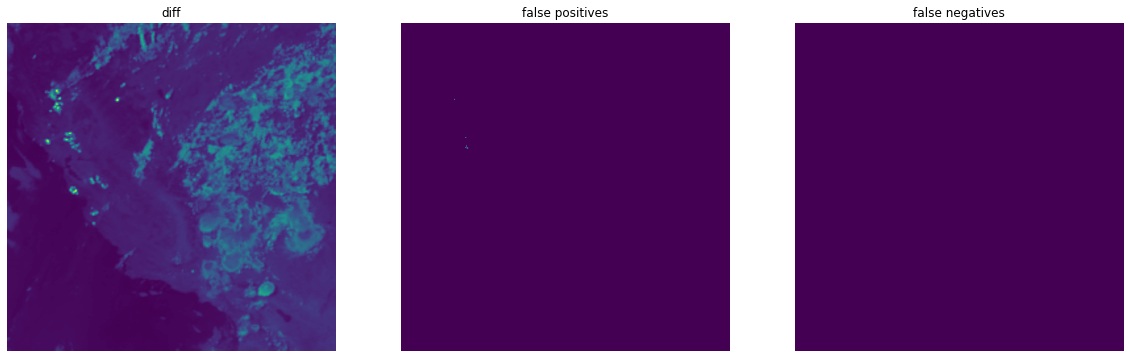

Text(0.5, 1.0, 'fire locations')

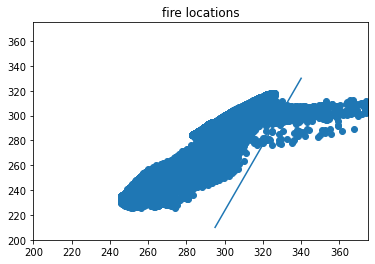

In [241]:
data07 = unsharpmask_sharpening_img(img07)
data14 = unsharpmask_sharpening_img(img14)
datafires = fire_mask(data07, data14)
datafires = np.logical_and(datafires, np.logical_not(cloud_mask))
stats = other_stats(fires, datafires)
print("number of fire pixels: " + str(np.count_nonzero(datafires)))
print("dice score: " + str(dice_score(fires, datafires)))
print("false positive count: " + str(np.count_nonzero(stats[0])))
print("false negative count: " + str(np.count_nonzero(stats[1])))
print("true positive rate: " + str(stats[2]))
print("positive predictive value: " + str(stats[3]))

fig, ax = plt.subplots(1, 3, figsize=(20, 10), gridspec_kw={'width_ratios': [1, 1, 1]})

diff = data07 - data14
im = ax[0].imshow(diff, aspect='equal')
ax[0].set_title('diff')
ax[0].axis('off')
# fig.colorbar(im)

im = ax[1].imshow(stats[0], aspect='equal')
ax[1].set_title('false positives')
ax[1].axis('off')

im = ax[2].imshow(stats[1], aspect='equal')
ax[2].set_title('false negatives')
ax[2].axis('off')

plt.show()

plt.scatter(data07, data14)
plt.plot([295, 340], [210, 330], label='fires')
plt.xlim([graph_min, graph_max])
plt.ylim([graph_min, graph_max])
plt.title('fire locations')

## ESRGAN

number of fire pixels: 13
dice score: 0.96
false positive count: 1
false negative count: 0
true positive rate: 1.0
positive predictive value: 0.9230769230769231


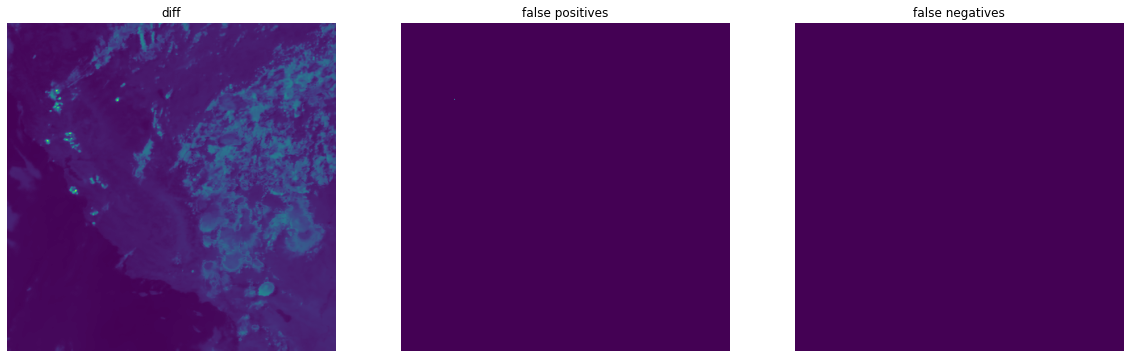

Text(0.5, 1.0, 'fire locations')

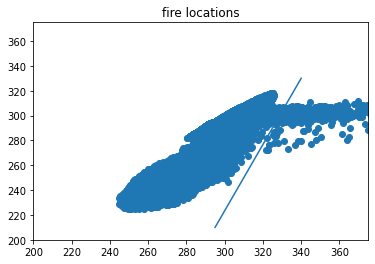

In [242]:
data07 = esrgan_sharpening_img(img07)
data14 = esrgan_sharpening_img(img14)
datafires = fire_mask(data07, data14)
datafires = np.logical_and(datafires, np.logical_not(cloud_mask))
stats = other_stats(fires, datafires)
print("number of fire pixels: " + str(np.count_nonzero(datafires)))
print("dice score: " + str(dice_score(fires, datafires)))
print("false positive count: " + str(np.count_nonzero(stats[0])))
print("false negative count: " + str(np.count_nonzero(stats[1])))
print("true positive rate: " + str(stats[2]))
print("positive predictive value: " + str(stats[3]))

fig, ax = plt.subplots(1, 3, figsize=(20, 10), gridspec_kw={'width_ratios': [1, 1, 1]})

diff = data07 - data14
im = ax[0].imshow(diff, aspect='equal')
ax[0].set_title('diff')
ax[0].axis('off')
# fig.colorbar(im)

im = ax[1].imshow(stats[0], aspect='equal')
ax[1].set_title('false positives')
ax[1].axis('off')

im = ax[2].imshow(stats[1], aspect='equal')
ax[2].set_title('false negatives')
ax[2].axis('off')

plt.show()

plt.scatter(data07, data14)
plt.plot([295, 340], [210, 330], label='fires')
plt.xlim([graph_min, graph_max])
plt.ylim([graph_min, graph_max])
plt.title('fire locations')